In [1]:

from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset

from torch.nn import CrossEntropyLoss, MSELoss

from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, QuantizeAct, BertSelfAttention, FP_BertSelfAttention, ClipLinear, BertAttention, FP_BertAttention
from utils_glue import *
from bertviz import model_view

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0 
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def do_eval(model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels, teacher_model=None):
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    for batch_ in tqdm(eval_dataloader, desc="Inference"):
        batch_ = tuple(t.to(device) for t in batch_)
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_

            # teacher attnmap test
            if teacher_model is not None:
                
                # logits, _, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
                
                # # logits, _, _, _, _ = model(input_ids, segment_ids, input_mask, teacher_probs=teacher_probs)
                # logits, _, _, _, _ = model(input_ids, segment_ids, input_mask, teacher_probs=(teacher_probs, teacher_values, teacher_reps))
                teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
                logits, student_atts, student_reps, student_probs, student_values  = model(input_ids, segment_ids, input_mask, teacher_outputs=(teacher_probs, teacher_values, teacher_reps, teacher_logits, teacher_atts), output_mode=output_mode, seq_lengths=seq_lengths)
            else:
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask)
        
        # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(
                preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, eval_labels.numpy())
    result['eval_loss'] = eval_loss
    return result

processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor   
}

output_modes = {
        "cola": "classification",
        "mnli": "classification",
        "mrpc": "classification",
        "sst-2": "classification",
        "sts-b": "regression",
        "qqp": "classification",
        "qnli": "classification",
        "rte": "classification"
}

default_params = {
        "cola": {"max_seq_length": 64,"batch_size":1,"eval_step": 50}, # No Aug : 50 Aug : 400
        "mnli": {"max_seq_length": 128,"batch_size":1,"eval_step":8000},
        "mrpc": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "sst-2": {"max_seq_length": 64,"batch_size":1,"eval_step":100},
        "sts-b": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "qqp": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "qnli": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "rte": {"max_seq_length": 128,"batch_size":1,"eval_step": 20}
    }

def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids


In [19]:
task_name = "sst-2"
bert_size = "large"

if bert_size == "large":
    layer_num = 24
    head_num = 16
else: 
    layer_num = 12
    head_num = 12
    
teacher_model = None

# torch.cuda.empty_cache()
# !nvidia-smi

# Device & Dataset

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

teacher_model_dir = os.path.join(model_dir,task_name)

# Processor & Task Info
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

if task_name in default_params:
    batch_size = default_params[task_name]["batch_size"]
    max_seq_length = default_params[task_name]["max_seq_length"]
    eval_step = default_params[task_name]["eval_step"]
    
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(teacher_model_dir, do_lower_case=True)


# Load Dataset
data_dir = os.path.join("data",task_name)
processed_data_dir = os.path.join(data_dir,'preprocessed')

eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
# dev_file = train_file = os.path.join(processed_data_dir,'dev.pkl') 
# eval_features = pickle.load(open(dev_file,'rb'))

eval_data, eval_labels = get_tensor_data("classification", eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

eval_examples = processor.get_dev_examples(data_dir)

# Sampling Sentence 
i = 0 
# num = 3
num = 1

for step, batch in enumerate(eval_dataloader):
    # model.train()
            
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    seq_length = seq_lengths[0]
    i = i + 1
    if i == num:
        break

input_ids_sliced = input_ids[:,:seq_length]
input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)


sample_sentence_a = str()
sample_sentence_b = str()
index = 0

for i, word in enumerate(tokens[1:-1]):
    if word == "[SEP]":
        break
    sample_sentence_a += word
    sample_sentence_a += " "
index = i

for i, word in enumerate(tokens[index+2:-1]):
    if word == "[SEP]":
        break
    sample_sentence_b += word
    sample_sentence_b += " "

sep_index = torch.where(input_ids[0] == 102)[0]

punc_index_1 = torch.where(input_ids[0] == 1010)[0] # comma
punc_index_2 = torch.where(input_ids[0] == 1012)[0] # period
punc_index = torch.cat([punc_index_1, punc_index_2])

if len(sample_sentence_b) > 1:
    sample_sentence_b_start = segment_ids[0].tolist().index(1)
else:
    sample_sentence_b_start = None

print(f"input_ids : {input_ids_sliced}")
print(f"tokens : {tokens}")
print(f"A : {sample_sentence_a}")
print(f"B : {sample_sentence_b}")
print(sep_index)
print("PUNC")
print(f"comma -> {punc_index_1}")
print(f"period -> {punc_index_2}")

for i, token in enumerate(tokens):
    tokens[i] = token # + "_" + str(i)


06/19 08:21:37 PM Writing example 0 of 872
06/19 08:21:37 PM *** Example ***
06/19 08:21:37 PM guid: dev-1
06/19 08:21:37 PM tokens: [CLS] it ' s a charming and often affecting journey . [SEP]
06/19 08:21:37 PM input_ids: 101 2009 1005 1055 1037 11951 1998 2411 12473 4990 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/19 08:21:37 PM input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/19 08:21:37 PM segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/19 08:21:37 PM label: 1
06/19 08:21:37 PM label_id: 1
input_ids : tensor([[  101,  2009,  1005,  1055,  1037, 11951,  1998,  2411, 12473,  4990,
          1012,   102]], device='cuda:0')
tokens : ['[CLS]', 'it', "'", 's', 'a', 'charming', 'and', 'often', 'affecting', 'journey', '.', '[SEP]']
A

In [21]:
cls_id = 101
sep_id = 102
comma_id = torch.tensor(tokenizer.convert_tokens_to_ids(","))
period_id = torch.tensor(tokenizer.convert_tokens_to_ids("."))

ids = input_ids_sliced.clone().detach().cpu()

ids[ids==cls_id] = -1
ids[ids==sep_id] = -2
ids[ids==comma_id] = -3
ids[ids==period_id] = -3
ids[ids>0] = -4

In [22]:
diff_dict = dict()
loss_mse = MSELoss()
loss_mae = torch.nn.L1Loss()

loss_func = loss_mse


for norm in ["prob", "tr", "wt"]:
    for token in ["sep", "punc", "cls", "other", "all"]:
        diff_dict[f"output_{norm}_{token}_diff"] = [ AverageMeter() for i in range(layer_num)]
        diff_dict[f"map_{norm}_{token}_diff"] = [ AverageMeter() for i in range(layer_num)]

if teacher_model is None:
    teacher_model_dir = os.path.join(model_dir,task_name)
    teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
    teacher_model.to(device)
    teacher_model.eval()

for name, module in teacher_model.named_modules():
    if isinstance(module, FP_BertAttention):    
        module.output_norm = True

num = 0
for st_model_name in ["1SB_O", "1SB_M"]:
# for st_model_name in ["1SB_M"]:
    
    if st_model_name == "1SB_O":
        num = "output"
    else:
        num = "map"

    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
    student_config = BertConfig.from_pretrained(student_model_dir)             
    student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    
    for name, module in student_model.named_modules():
        if isinstance(module, BertAttention):    
            module.output_norm = True
        
    model = student_model

    count = 0
    for batch in tqdm(eval_dataloader):
        if count >= 1:
            break
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
        seq_length = seq_lengths[0]

        input_ids_sliced = input_ids[:,:seq_length]

        teacher_outputs = teacher_model(input_ids_sliced.to(device))
        student_outputs  = model(input_ids_sliced.to(device), teacher_outputs=None)

        teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_outputs
        student_logits, student_atts, student_reps, student_probs, student_zip = student_outputs
        
        ids = input_ids_sliced.clone().detach().cpu()

        ids[ids==cls_id] = -1
        ids[ids==sep_id] = -2
        ids[ids==comma_id] = -3
        ids[ids==period_id] = -3
        ids[ids>0] = -4
        
        for l in range(layer_num):

            tc_prob = teacher_probs[l]
            st_prob = student_probs[l]

            tc_context, tc_output, tc_value, tc_output_hs, tc_norm = teacher_zip[l]
            st_context, st_output, st_value, st_output_hs, st_norm = student_zip[l]

            tc_transformed_norm, tc_weighted_norm, tc_summed_weighted_norm, tc_transformed = tc_norm
            st_transformed_norm, st_weighted_norm, st_summed_weighted_norm, st_transformed = st_norm
            
            tc_transformed_layer = tc_transformed.sum(dim=1)
            st_transformed_layer = st_transformed.sum(dim=1)
            
            diff_dict[f"{num}_prob_cls_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-1]) - torch.mean(st_prob[0,:,:,ids[0]==-1])).abs().item())
            diff_dict[f"{num}_prob_sep_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-2]) - torch.mean(st_prob[0,:,:,ids[0]==-2])).abs().item())
            diff_dict[f"{num}_prob_other_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-4]) - torch.mean(st_prob[0,:,:,ids[0]==-4])).abs().item())
            diff_dict[f"{num}_prob_all_diff"][l].update((torch.mean(tc_prob[0,:,:,:]) - torch.mean(st_prob[0,:,:,:])).abs().item())

            diff_dict[f"{num}_tr_cls_diff"][l].update((torch.mean(tc_transformed_norm[0,:,ids[0]==-1]) -torch.mean(st_transformed_norm[0,:,ids[0]==-1])).abs().item())
            diff_dict[f"{num}_tr_sep_diff"][l].update((torch.mean(tc_transformed_norm[0,:,ids[0]==-2]) - torch.mean(st_transformed_norm[0,:,ids[0]==-2])).abs().item())
            diff_dict[f"{num}_tr_other_diff"][l].update((torch.mean(tc_transformed_norm[0,:,ids[0]==-4]) - torch.mean(st_transformed_norm[0,:,ids[0]==-4])).abs().item())
            diff_dict[f"{num}_tr_all_diff"][l].update((torch.mean(tc_transformed_norm[0,:,:]) - torch.mean(st_transformed_norm[0,:,:])).abs().item())
            
#             diff_dict[f"{num}_tr_cls_diff"][l].update(torch.mean(tc_transformed_layer[0,ids[0]==-1,:]), torch.mean(st_transformed_layer[0,ids[0]==-1,:])).item())
#             diff_dict[f"{num}_tr_sep_diff"][l].update(torch.mean(tc_transformed_layer[0,ids[0]==-2,:]), torch.mean(st_transformed_layer[0,ids[0]==-2,:])).item())
#             diff_dict[f"{num}_tr_other_diff"][l].update(torch.mean(tc_transformed_layer[0,ids[0]==-4,:]), torch.mean(st_transformed_layer[0,ids[0]==-4,:])).item())
#             diff_dict[f"{num}_tr_all_diff"][l].update(torch.mean(tc_transformed_layer[0,:,:]), torch.mean(st_transformed_layer[0,:,:])).item())

#             diff_dict[f"{num}_wt_cls_diff"][l].update(((tc_weighted_norm[0,:,:,ids[0]==-1]) - torch.mean(st_weighted_norm[0,:,:,ids[0]==-1])).abs().item())
#             diff_dict[f"{num}_wt_sep_diff"][l].update(((tc_weighted_norm[0,:,:,ids[0]==-2]) - torch.mean(st_weighted_norm[0,:,:,ids[0]==-2])).abs().item())
#             diff_dict[f"{num}_wt_other_diff"][l].update(((tc_weighted_norm[0,:,:,ids[0]==-4]) - torch.mean(st_weighted_norm[0,:,:,ids[0]==-4])).abs().item())
            
            diff_dict[f"{num}_wt_cls_diff"][l].update((torch.mean(tc_summed_weighted_norm[0,:,ids[0]==-1]) - torch.mean(st_summed_weighted_norm[0,:,ids[0]==-1])).abs().item())
            diff_dict[f"{num}_wt_sep_diff"][l].update((torch.mean(tc_summed_weighted_norm[0,:,ids[0]==-2]) - torch.mean(st_summed_weighted_norm[0,:,ids[0]==-2])).abs().item())
            diff_dict[f"{num}_wt_other_diff"][l].update((torch.mean(tc_summed_weighted_norm[0,:,ids[0]==-4]) - torch.mean(st_summed_weighted_norm[0,:,ids[0]==-4])).abs().item())
            diff_dict[f"{num}_wt_all_diff"][l].update((torch.mean(tc_summed_weighted_norm[0,:,:]) - torch.mean(st_summed_weighted_norm[0,:,:])).abs().item())
            
            if -3 in ids:
                diff_dict[f"{num}_prob_punc_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-3]) - torch.mean(st_prob[0,:,:,ids[0]==-3])).abs().item())
                diff_dict[f"{num}_tr_punc_diff"][l].update((torch.mean(tc_transformed_layer[0,ids[0]==-3,:]) - torch.mean(st_transformed_layer[0,ids[0]==-3,:])).abs().item())
                # diff_dict[f"{num}_wt_punc_diff"][l].update(((tc_weighted_norm[0,:,:,ids[0]==-3]) - torch.mean(st_weighted_norm[0,:,:,ids[0]==-3])).abs().item())
                diff_dict[f"{num}_wt_punc_diff"][l].update((torch.mean(tc_summed_weighted_norm[0,:,ids[0]==-3]) - torch.mean(st_summed_weighted_norm[0,:,ids[0]==-3])).abs().item())
        count+=1

06/19 08:21:43 PM Loading model models/BERT_large/sst-2/pytorch_model.bin
06/19 08:21:44 PM loading model...
06/19 08:21:44 PM done!
06/19 08:21:44 PM loading configuration file output/BERT_large/sst-2/exploration/1SB_O/config.json
06/19 08:21:51 PM Loading model output/BERT_large/sst-2/exploration/1SB_O/pytorch_model.bin
06/19 08:21:52 PM loading model...
06/19 08:21:53 PM done!


  0%|▎                                                                                                                                                                                                                                                                               | 1/872 [00:00<03:37,  4.00it/s]

06/19 08:21:53 PM loading configuration file output/BERT_large/sst-2/exploration/1SB_M/config.json


06/19 08:22:00 PM Loading model output/BERT_large/sst-2/exploration/1SB_M/pytorch_model.bin
06/19 08:22:02 PM loading model...
06/19 08:22:02 PM done!


  0%|▎                                                                                                                                                                                                                                                                               | 1/872 [00:00<04:37,  3.14it/s]


In [23]:
tc_transformed_layer.shape

torch.Size([1, 12, 1024])

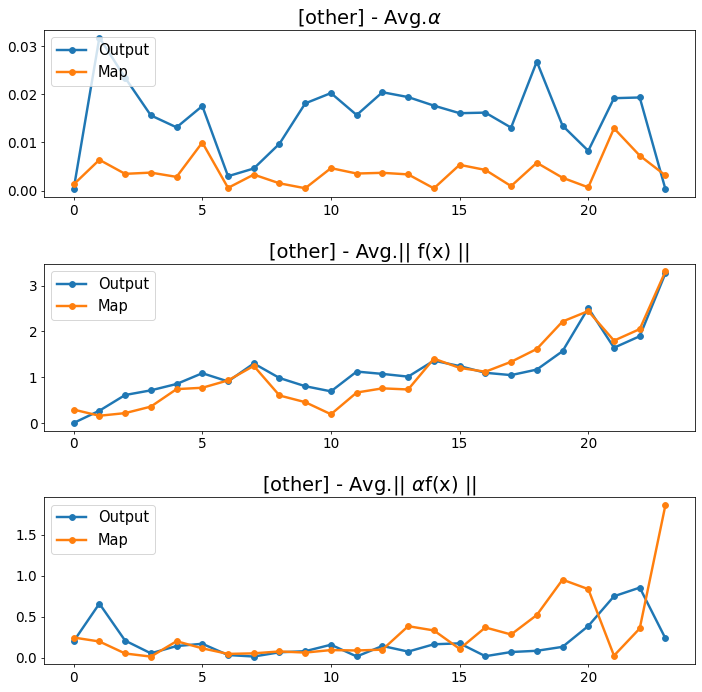

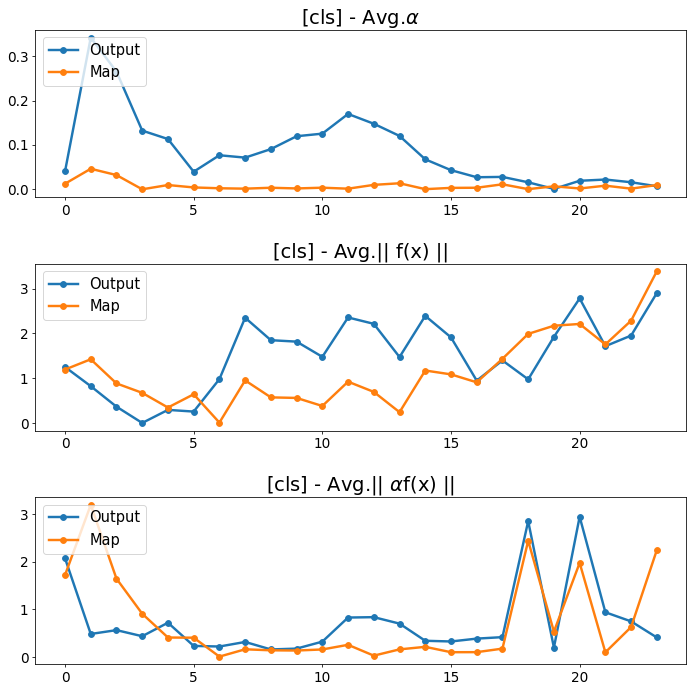

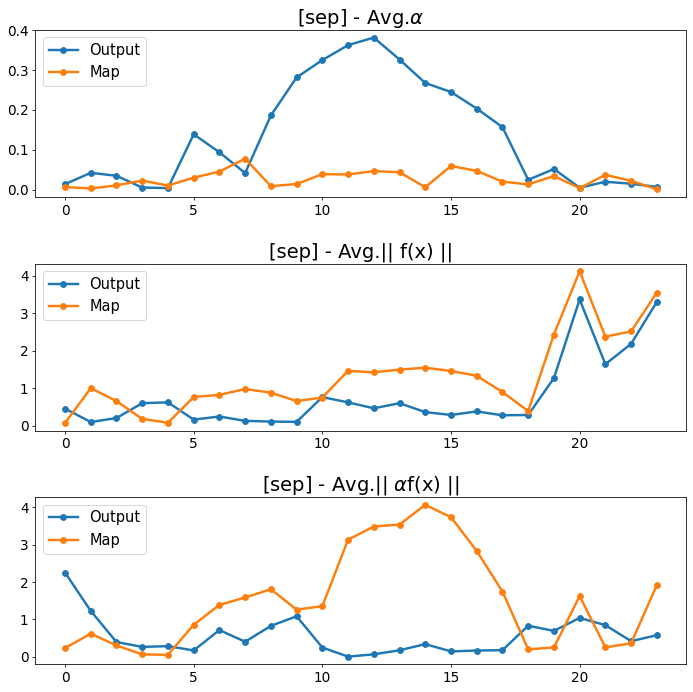

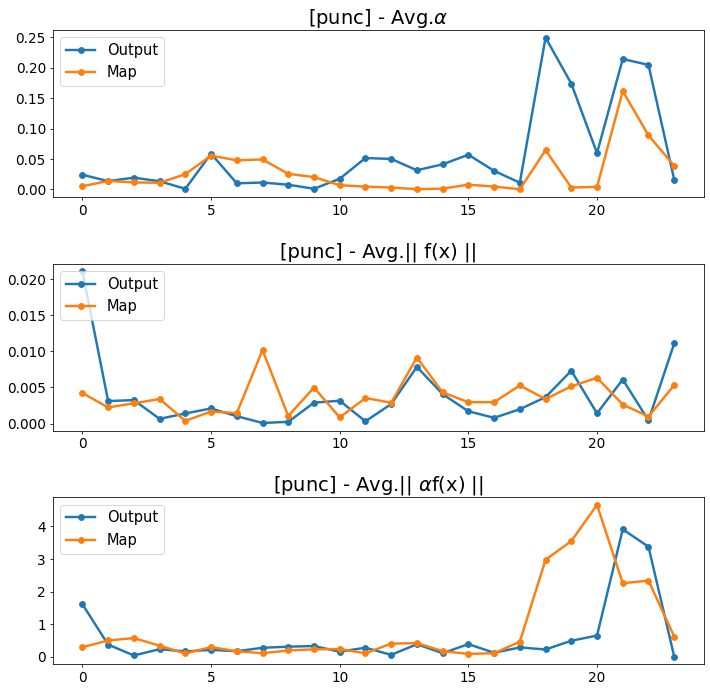

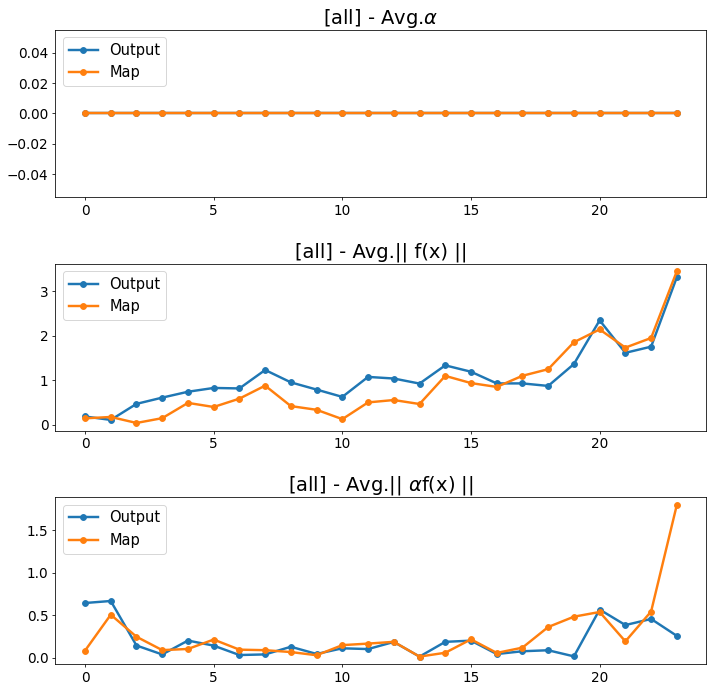

In [24]:
map_c = "orange"
out_c = "r"
graph_dict = dict()
for norm in ["prob", "tr", "wt"]:
    for token in ["sep", "punc", "cls", "other", "all"]:
        graph_dict[f"output_{norm}_{token}_diff"] = []
        graph_dict[f"map_{norm}_{token}_diff"] = []
        
for l in range(layer_num):
    for norm in ["prob", "tr", "wt"]:
        for token in ["sep", "punc", "cls", "other", "all"]:
            graph_dict[f"output_{norm}_{token}_diff"].append(diff_dict[f"output_{norm}_{token}_diff"][l].avg)
            graph_dict[f"map_{norm}_{token}_diff"].append(diff_dict[f"map_{norm}_{token}_diff"][l].avg)

for name in ["other", "cls", "sep", "punc", "all"]:
    fig, [ax1,ax2, ax3] = plt.subplots(3, 1, figsize=(12, 12), dpi=70)
    fig.subplots_adjust(hspace=0.4)
    ax1.set_title(f"[{name}] - Avg.$α$", fontsize=20)
    ax1.plot(list(range(layer_num)), graph_dict[f"output_prob_{name}_diff"], linewidth=2.5, label="Output", marker='o')
    ax1.plot(list(range(layer_num)), graph_dict[f"map_prob_{name}_diff"], linewidth=2.5, label="Map", marker='o')
    ax1.legend(loc=2, fontsize=15)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    ax2.set_title(f"[{name}] - Avg.|| f(x) ||", fontsize=20)
    ax2.plot(list(range(layer_num)), graph_dict[f"output_tr_{name}_diff"], linewidth=2.5, label="Output", marker='o')
    ax2.plot(list(range(layer_num)), graph_dict[f"map_tr_{name}_diff"], linewidth=2.5, label="Map", marker='o')
    ax2.legend(loc=2, fontsize=15)
    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    
    ax3.set_title(f"[{name}] - Avg.|| $α$f(x) ||", fontsize=20)
    ax3.plot(list(range(layer_num)), graph_dict[f"output_wt_{name}_diff"], linewidth=2.5, label="Output", marker='o')
    ax3.plot(list(range(layer_num)), graph_dict[f"map_wt_{name}_diff"], linewidth=2.5, label="Map", marker='o')
    ax3.legend(loc=2, fontsize=15)
    ax3.tick_params(axis='x', labelsize=14)
    ax3.tick_params(axis='y', labelsize=14)


In [16]:
teacher_list = None
student_list = None
student_model = None
student_outputs = None
teacher_outputs = None
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
diff_dict = dict()
loss_mse = MSELoss()
loss_mae = torch.nn.L1Loss()

loss_func = loss_mse


for norm in ["prob", "tr", "wt"]:
    for token in ["sep", "punc", "cls", "other", "all"]:
        diff_dict[f"output_{norm}_{token}_diff"] = [ AverageMeter() for i in range(layer_num)]
        diff_dict[f"map_{norm}_{token}_diff"] = [ AverageMeter() for i in range(layer_num)]

if teacher_model is None:
    teacher_model_dir = os.path.join(model_dir,task_name)
    teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
    teacher_model.to(device)
    teacher_model.eval()

for name, module in teacher_model.named_modules():
    if isinstance(module, FP_BertAttention):    
        module.output_norm = True

num = 0
for st_model_name in ["1SB_O", "1SB_M"]:
# for st_model_name in ["1SB_M"]:
    
    if st_model_name == "1SB_O":
        num = "output"
    else:
        num = "map"

    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
    student_config = BertConfig.from_pretrained(student_model_dir)             
    student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    
    for name, module in student_model.named_modules():
        if isinstance(module, BertAttention):    
            module.output_norm = True
        
    model = student_model

    count = 0
    for batch in tqdm(eval_dataloader):
        if count >= 1:
            break
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
        seq_length = seq_lengths[0]

        input_ids_sliced = input_ids[:,:seq_length]

        teacher_outputs = teacher_model(input_ids_sliced.to(device))
        student_outputs  = model(input_ids_sliced.to(device), teacher_outputs=None)

        teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_outputs
        student_logits, student_atts, student_reps, student_probs, student_zip = student_outputs
        
        ids = input_ids_sliced.clone().detach().cpu()

        ids[ids==cls_id] = -1
        ids[ids==sep_id] = -2
        ids[ids==comma_id] = -3
        ids[ids==period_id] = -3
        ids[ids>0] = -4
        
        for l in range(layer_num):

            tc_prob = teacher_probs[l]
            st_prob = student_probs[l]

            tc_context, tc_output, tc_value, tc_output_hs, tc_norm = teacher_zip[l]
            st_context, st_output, st_value, st_output_hs, st_norm = student_zip[l]

            tc_transformed_norm, tc_weighted_norm, tc_summed_weighted_norm, tc_transformed = tc_norm
            st_transformed_norm, st_weighted_norm, st_summed_weighted_norm, st_transformed = st_norm
            
            tc_transformed_layer = tc_transformed.sum(dim=1)
            st_transformed_layer = st_transformed.sum(dim=1)
            
            diff_dict[f"{num}_prob_cls_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-1]) - torch.mean(st_prob[0,:,:,ids[0]==-1])).abs().item())
            diff_dict[f"{num}_prob_sep_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-2]) - torch.mean(st_prob[0,:,:,ids[0]==-2])).abs().item())
            diff_dict[f"{num}_prob_other_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-4]) - torch.mean(st_prob[0,:,:,ids[0]==-4])).abs().item())
            diff_dict[f"{num}_prob_all_diff"][l].update((torch.mean(tc_prob[0,:,:,:]) - torch.mean(st_prob[0,:,:,:])).abs().item())

            diff_dict[f"{num}_tr_cls_diff"][l].update(loss_func((tc_transformed_norm[0,:,ids[0]==-1]), (st_transformed_norm[0,:,ids[0]==-1])).item())
            diff_dict[f"{num}_tr_sep_diff"][l].update(loss_func((tc_transformed_norm[0,:,ids[0]==-2]), (st_transformed_norm[0,:,ids[0]==-2])).item())
            diff_dict[f"{num}_tr_other_diff"][l].update(loss_func((tc_transformed_norm[0,:,ids[0]==-4]), (st_transformed_norm[0,:,ids[0]==-4])).item())
            diff_dict[f"{num}_tr_all_diff"][l].update(loss_func((tc_transformed_norm[0,:,:]), (st_transformed_norm[0,:,:])).item())
            
#             diff_dict[f"{num}_tr_cls_diff"][l].update(loss_func((tc_transformed_layer[0,ids[0]==-1,:]), (st_transformed_layer[0,ids[0]==-1,:])).item())
#             diff_dict[f"{num}_tr_sep_diff"][l].update(loss_func((tc_transformed_layer[0,ids[0]==-2,:]), (st_transformed_layer[0,ids[0]==-2,:])).item())
#             diff_dict[f"{num}_tr_other_diff"][l].update(loss_func((tc_transformed_layer[0,ids[0]==-4,:]), (st_transformed_layer[0,ids[0]==-4,:])).item())
#             diff_dict[f"{num}_tr_all_diff"][l].update(loss_func((tc_transformed_layer[0,:,:]), (st_transformed_layer[0,:,:])).item())

#             diff_dict[f"{num}_wt_cls_diff"][l].update(((tc_weighted_norm[0,:,:,ids[0]==-1]) - (st_weighted_norm[0,:,:,ids[0]==-1])).abs().item())
#             diff_dict[f"{num}_wt_sep_diff"][l].update(((tc_weighted_norm[0,:,:,ids[0]==-2]) - (st_weighted_norm[0,:,:,ids[0]==-2])).abs().item())
#             diff_dict[f"{num}_wt_other_diff"][l].update(((tc_weighted_norm[0,:,:,ids[0]==-4]) - (st_weighted_norm[0,:,:,ids[0]==-4])).abs().item())
            
            diff_dict[f"{num}_wt_cls_diff"][l].update(loss_func((tc_summed_weighted_norm[0,:,ids[0]==-1]),(st_summed_weighted_norm[0,:,ids[0]==-1])).item())
            diff_dict[f"{num}_wt_sep_diff"][l].update(loss_func((tc_summed_weighted_norm[0,:,ids[0]==-2]),(st_summed_weighted_norm[0,:,ids[0]==-2])).item())
            diff_dict[f"{num}_wt_other_diff"][l].update(loss_func((tc_summed_weighted_norm[0,:,ids[0]==-4]), (st_summed_weighted_norm[0,:,ids[0]==-4])).item())
            diff_dict[f"{num}_wt_all_diff"][l].update(loss_func((tc_summed_weighted_norm[0,:,:]), (st_summed_weighted_norm[0,:,:])).item())
            
            if -3 in ids:
                diff_dict[f"{num}_prob_punc_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-3]) - torch.mean(st_prob[0,:,:,ids[0]==-3])).abs().item())
                diff_dict[f"{num}_tr_punc_diff"][l].update(loss_func((tc_transformed_layer[0,ids[0]==-3,:]),(st_transformed_layer[0,ids[0]==-3,:])).item())
                # diff_dict[f"{num}_wt_punc_diff"][l].update(((tc_weighted_norm[0,:,:,ids[0]==-3]) - (st_weighted_norm[0,:,:,ids[0]==-3])).abs().item())
                diff_dict[f"{num}_wt_punc_diff"][l].update(loss_func((tc_summed_weighted_norm[0,:,ids[0]==-3]), (st_summed_weighted_norm[0,:,ids[0]==-3])).item())
        count+=1

In [ ]:
diff_dict = dict()
loss_mse = MSELoss()
loss_mae = torch.nn.L1Loss()
loss_cos = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
loss_func = loss_mse


for norm in ["prob", "tr", "wt"]:
    for token in ["sep", "punc", "cls", "other", "all"]:
        diff_dict[f"output_{norm}_{token}_diff"] = [ AverageMeter() for i in range(layer_num)]
        diff_dict[f"map_{norm}_{token}_diff"] = [ AverageMeter() for i in range(layer_num)]

if teacher_model is None:
    teacher_model_dir = os.path.join(model_dir,task_name)
    teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
    teacher_model.to(device)
    teacher_model.eval()

for name, module in teacher_model.named_modules():
    if isinstance(module, FP_BertAttention):    
        module.output_norm = True

num = 0
for st_model_name in ["1SB_O", "1SB_M"]:
# for st_model_name in ["1SB_M"]:
    
    if st_model_name == "1SB_O":
        num = "output"
    else:
        num = "map"

    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
    student_config = BertConfig.from_pretrained(student_model_dir)             
    student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    
    for name, module in student_model.named_modules():
        if isinstance(module, BertAttention):    
            module.output_norm = True
        
    model = student_model

    count = 0
    for batch in tqdm(eval_dataloader):
        if count >= 1:
            break
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
        seq_length = seq_lengths[0]

        input_ids_sliced = input_ids[:,:seq_length]

        teacher_outputs = teacher_model(input_ids_sliced.to(device))
        student_outputs  = model(input_ids_sliced.to(device), teacher_outputs=None)

        teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_outputs
        student_logits, student_atts, student_reps, student_probs, student_zip = student_outputs
        
        ids = input_ids_sliced.clone().detach().cpu()

        ids[ids==cls_id] = -1
        ids[ids==sep_id] = -2
        ids[ids==comma_id] = -3
        ids[ids==period_id] = -3
        ids[ids>0] = -4
        
        for l in range(layer_num):

            tc_prob = teacher_probs[l]
            st_prob = student_probs[l]

            tc_context, tc_output, tc_value, tc_output_hs, tc_norm = teacher_zip[l]
            st_context, st_output, st_value, st_output_hs, st_norm = student_zip[l]

            tc_transformed_norm, tc_weighted_norm, tc_summed_weighted_norm, tc_transformed, tc_weighted, tc_summed_weighted = tc_norm
            st_transformed_norm, st_weighted_norm, st_summed_weighted_norm, st_transformed, st_weighted, st_summed_weighted = st_norm
            
            tc_transformed_layer = tc_transformed.sum(dim=1)
            st_transformed_layer = st_transformed.sum(dim=1)
            
            diff_dict[f"{num}_prob_cls_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-1]) - torch.mean(st_prob[0,:,:,ids[0]==-1])).abs().item())
            diff_dict[f"{num}_prob_sep_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-2]) - torch.mean(st_prob[0,:,:,ids[0]==-2])).abs().item())
            diff_dict[f"{num}_prob_other_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-4]) - torch.mean(st_prob[0,:,:,ids[0]==-4])).abs().item())
            diff_dict[f"{num}_prob_all_diff"][l].update((torch.mean(tc_prob[0,:,:,:]) - torch.mean(st_prob[0,:,:,:])).abs().item())
            
            diff_dict[f"{num}_tr_cls_diff"][l].update(loss_func((tc_transformed_layer[0,ids[0]==-1,:]), (st_transformed_layer[0,ids[0]==-1,:])).item())
            diff_dict[f"{num}_tr_sep_diff"][l].update(loss_func((tc_transformed_layer[0,ids[0]==-2,:]), (st_transformed_layer[0,ids[0]==-2,:])).item())
            diff_dict[f"{num}_tr_other_diff"][l].update(loss_func((tc_transformed_layer[0,ids[0]==-4,:]), (st_transformed_layer[0,ids[0]==-4,:])).item())
            diff_dict[f"{num}_tr_all_diff"][l].update(loss_func((tc_transformed_layer[0,:,:]), (st_transformed_layer[0,:,:])).item())
            
            diff_dict[f"{num}_wt_cls_diff"][l].update(loss_func((tc_summed_weighted[0,:,ids[0]==-1]),(st_summed_weighted[0,:,ids[0]==-1])).item())
            diff_dict[f"{num}_wt_sep_diff"][l].update(loss_func((tc_summed_weighted[0,:,ids[0]==-2]),(st_summed_weighted[0,:,ids[0]==-2])).item())
            diff_dict[f"{num}_wt_other_diff"][l].update(loss_func((tc_summed_weighted[0,:,ids[0]==-4]), (st_summed_weighted[0,:,ids[0]==-4])).item())
            diff_dict[f"{num}_wt_all_diff"][l].update(loss_func((tc_summed_weighted[0,:,:]), (st_summed_weighted[0,:,:])).item())
            
            if -3 in ids:
                diff_dict[f"{num}_prob_punc_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-3]) - torch.mean(st_prob[0,:,:,ids[0]==-3])).abs().item())
                diff_dict[f"{num}_tr_punc_diff"][l].update(loss_func((tc_transformed_layer[0,ids[0]==-3,:]),(st_transformed_layer[0,ids[0]==-3,:])).item())
                # diff_dict[f"{num}_wt_punc_diff"][l].update(((tc_weighted[0,:,:,ids[0]==-3]) - (st_weighted[0,:,:,ids[0]==-3])).abs().item())
                diff_dict[f"{num}_wt_punc_diff"][l].update(loss_func((tc_summed_weighted[0,:,ids[0]==-3]), (st_summed_weighted[0,:,ids[0]==-3])).item())
        count+=1